# CSC 215 - MiniProject 4
## Khoi Hoang

In [2]:
import os
import csv
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections
import sklearn.feature_extraction.text as sk_text
import scipy as sp
import math
from scipy.stats import zscore
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib.pyplot import figure, show
from IPython.display import Markdown, display
from sklearn import metrics

%matplotlib inline

In [3]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    
# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)    

# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()    
    
# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)
    
# Print markdown style
def printmd(string):
    display(Markdown(string))
    
def to_sequences(seq_size, data, target):
    x = []
    y = []

    for i in range(len(data)-seq_size-1):
        window = data[i:(i+seq_size)]
        after_window = data.iloc[(i+seq_size)]
        window = window.values.tolist()
        x.append(window)
        y.append(after_window[target])
        
    return np.array(x),np.array(y)

def to_sequences_continuous(seq_size, data, target, period):
    x = []
    y = []

    for i in range(len(data)-seq_size-period-1):
        window = data[i:(i+seq_size)]
        after_window = data[(i+seq_size):(i+seq_size+period)]
        window = window.values.tolist()
        after_window = after_window[target].values
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)

# Data Preprocessing

In [72]:
df = pd.read_csv('CSC215_Project4_Stock_Price.csv')

In [73]:
df.drop(columns=['Adj_Close','Date'], inplace=True)
df.head()

,Open,High,Low,Close,Volume
0,3.812500,4.156250,3.812500,4.125000,3675600
1,4.125000,4.125000,4.000000,4.015625,1077600
2,4.000000,4.031250,3.953125,4.000000,437200
3,4.000000,4.000000,3.843750,3.843750,1883600
4,3.734375,3.734375,3.390625,3.390625,7931600


In [74]:
encode_numeric_zscore(df, 'Open')
encode_numeric_zscore(df, 'High')
encode_numeric_zscore(df, 'Low')
encode_numeric_zscore(df, 'Volume')
print(df.shape)
df.tail()

(4392, 5)


,Open,High,Low,Close,Volume
4387,2.782154,2.754177,2.787407,113.309998,-0.575988
4388,2.739700,2.735310,2.732368,111.870003,-0.048610
4389,2.723320,2.700885,2.701641,112.230003,0.155816
4390,2.737694,2.714457,2.760732,112.339996,-0.390000
4391,2.732346,2.777017,2.761069,113.190002,-0.167936


In [75]:
x, y = to_xy(df, 'Close')

In [76]:
x_train = x[0:int(0.7*len(x))]
x_test = x[int(0.7*len(x)):]
y_train = y[0:int(0.7*len(y))]
y_test = y[int(0.7*len(y)):]

In [77]:
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=43)

In [78]:
x_test.shape

(1318, 4)

# Fully Connected Neural Network

In [4]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import LSTM, Embedding, Bidirectional, Conv2D, MaxPooling2D, TimeDistributed
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from tensorflow import keras

Using TensorFlow backend.


In [80]:
checkpointer = ModelCheckpoint(filepath="save/nn.hdf5", verbose=0, save_best_only=True) # save best model
for i in range(5):
    printmd("\n**Iteration**: {}".format(i))
    model = Sequential()

    model.add(Dense(128, input_dim=x_train.shape[1], activation='relu')) # Hidden 1     #  why input_dim=x.shape[1]?  
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu')) # Hidden 2
    model.add(Dropout(0.25))
    model.add(Dense(32, activation='relu')) 
    model.add(Dense(1)) # Output

    model.compile(loss='mean_squared_error', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor,checkpointer],verbose=2,epochs=500, batch_size=32, shuffle=True)

print('Training finished...Loading the best model')  
print()
model.load_weights("save/nn.hdf5") # load weights from best model    


**Iteration**: 0

Train on 3074 samples, validate on 1318 samples
Epoch 1/500
 - 5s - loss: 202.0562 - val_loss: 706.7568
Epoch 2/500
 - 0s - loss: 34.0060 - val_loss: 320.3829
Epoch 3/500
 - 0s - loss: 14.2902 - val_loss: 29.3341
Epoch 4/500
 - 0s - loss: 6.9774 - val_loss: 34.4929
Epoch 5/500
 - 0s - loss: 5.0376 - val_loss: 9.0658
Epoch 6/500
 - 0s - loss: 5.4209 - val_loss: 10.7652
Epoch 7/500
 - 0s - loss: 4.6031 - val_loss: 1.6759
Epoch 8/500
 - 0s - loss: 4.0116 - val_loss: 0.9657
Epoch 9/500
 - 0s - loss: 4.1155 - val_loss: 17.3785
Epoch 10/500
 - 0s - loss: 4.4731 - val_loss: 2.6724
Epoch 11/500
 - 0s - loss: 4.0817 - val_loss: 1.6240
Epoch 12/500
 - 0s - loss: 4.0084 - val_loss: 0.8039
Epoch 13/500
 - 0s - loss: 4.0582 - val_loss: 1.1988
Epoch 14/500
 - 0s - loss: 3.8573 - val_loss: 0.7555
Epoch 15/500
 - 0s - loss: 3.7752 - val_loss: 0.7609
Epoch 16/500
 - 0s - loss: 3.5667 - val_loss: 2.1325
Epoch 17/500
 - 0s - loss: 3.7250 - val_loss: 1.9559
Epoch 18/500
 - 0s - loss: 3.5108 - val_loss: 0.


**Iteration**: 1

Train on 3074 samples, validate on 1318 samples
Epoch 1/500
 - 5s - loss: 217.6636 - val_loss: 341.4458
Epoch 2/500
 - 0s - loss: 37.1892 - val_loss: 682.9837
Epoch 3/500
 - 0s - loss: 15.7642 - val_loss: 214.4050
Epoch 4/500
 - 0s - loss: 7.7395 - val_loss: 41.8669
Epoch 5/500
 - 0s - loss: 6.5251 - val_loss: 8.8059
Epoch 6/500
 - 0s - loss: 4.7972 - val_loss: 14.6890
Epoch 7/500
 - 0s - loss: 4.4881 - val_loss: 13.7452
Epoch 8/500
 - 0s - loss: 4.3976 - val_loss: 1.4591
Epoch 9/500
 - 0s - loss: 3.9150 - val_loss: 1.1404
Epoch 10/500
 - 0s - loss: 4.1602 - val_loss: 11.8671
Epoch 11/500
 - 0s - loss: 3.9929 - val_loss: 9.8889
Epoch 12/500
 - 0s - loss: 3.9794 - val_loss: 10.3303
Epoch 13/500
 - 0s - loss: 3.7777 - val_loss: 14.8949
Epoch 14/500
 - 0s - loss: 3.8182 - val_loss: 1.9643
Epoch 00014: early stopping



**Iteration**: 2

Train on 3074 samples, validate on 1318 samples
Epoch 1/500
 - 5s - loss: 238.7751 - val_loss: 142.2056
Epoch 2/500
 - 0s - loss: 43.1806 - val_loss: 618.7686
Epoch 3/500
 - 0s - loss: 18.4831 - val_loss: 218.8488
Epoch 4/500
 - 0s - loss: 7.9986 - val_loss: 47.1625
Epoch 5/500
 - 0s - loss: 6.2089 - val_loss: 17.7729
Epoch 6/500
 - 0s - loss: 4.8596 - val_loss: 16.8153
Epoch 7/500
 - 0s - loss: 4.6276 - val_loss: 10.7346
Epoch 8/500
 - 0s - loss: 4.3959 - val_loss: 5.5141
Epoch 9/500
 - 0s - loss: 4.1078 - val_loss: 4.1541
Epoch 10/500
 - 0s - loss: 4.0127 - val_loss: 1.4844
Epoch 11/500
 - 0s - loss: 4.0847 - val_loss: 1.2381
Epoch 12/500
 - 0s - loss: 3.9145 - val_loss: 1.0911
Epoch 13/500
 - 0s - loss: 3.6696 - val_loss: 4.2918
Epoch 14/500
 - 0s - loss: 3.9225 - val_loss: 5.3868
Epoch 15/500
 - 0s - loss: 3.7360 - val_loss: 1.5979
Epoch 16/500
 - 0s - loss: 3.4686 - val_loss: 2.4449
Epoch 17/500
 - 0s - loss: 3.5391 - val_loss: 0.8711
Epoch 18/500
 - 0s - loss: 3.4627 - val_loss: 


**Iteration**: 3

Train on 3074 samples, validate on 1318 samples
Epoch 1/500
 - 6s - loss: 237.5039 - val_loss: 264.6248
Epoch 2/500
 - 0s - loss: 44.5510 - val_loss: 804.0712
Epoch 3/500
 - 0s - loss: 13.5256 - val_loss: 167.4516
Epoch 4/500
 - 0s - loss: 7.5128 - val_loss: 56.6868
Epoch 5/500
 - 0s - loss: 6.0453 - val_loss: 33.9089
Epoch 6/500
 - 0s - loss: 5.6254 - val_loss: 3.7632
Epoch 7/500
 - 0s - loss: 4.8433 - val_loss: 2.5888
Epoch 8/500
 - 0s - loss: 4.3641 - val_loss: 1.4065
Epoch 9/500
 - 0s - loss: 4.1552 - val_loss: 7.2212
Epoch 10/500
 - 0s - loss: 4.4693 - val_loss: 2.3375
Epoch 11/500
 - 0s - loss: 3.9003 - val_loss: 4.4420
Epoch 12/500
 - 0s - loss: 3.9944 - val_loss: 0.8938
Epoch 13/500
 - 0s - loss: 3.8021 - val_loss: 0.9906
Epoch 14/500
 - 0s - loss: 3.5974 - val_loss: 0.8782
Epoch 15/500
 - 0s - loss: 3.8197 - val_loss: 13.4800
Epoch 16/500
 - 0s - loss: 3.5702 - val_loss: 6.8251
Epoch 17/500
 - 0s - loss: 3.3575 - val_loss: 1.7644
Epoch 18/500
 - 0s - loss: 3.5703 - val_loss: 1


**Iteration**: 4

Train on 3074 samples, validate on 1318 samples
Epoch 1/500
 - 6s - loss: 225.0996 - val_loss: 156.8035
Epoch 2/500
 - 0s - loss: 39.9888 - val_loss: 678.4245
Epoch 3/500
 - 0s - loss: 16.3573 - val_loss: 170.6255
Epoch 4/500
 - 0s - loss: 7.7795 - val_loss: 34.0032
Epoch 5/500
 - 0s - loss: 5.5854 - val_loss: 14.7025
Epoch 6/500
 - 0s - loss: 4.9831 - val_loss: 7.7776
Epoch 7/500
 - 0s - loss: 4.1217 - val_loss: 1.3237
Epoch 8/500
 - 0s - loss: 4.2929 - val_loss: 1.8830
Epoch 9/500
 - 0s - loss: 3.8826 - val_loss: 2.2752
Epoch 10/500
 - 0s - loss: 3.7545 - val_loss: 7.1701
Epoch 11/500
 - 0s - loss: 3.7741 - val_loss: 1.8333
Epoch 12/500
 - 0s - loss: 3.6427 - val_loss: 1.8949
Epoch 00012: early stopping
Training finished...Loading the best model



In [81]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 128)               640       
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 33        
Total params: 11,009
Trainable params: 11,009
Non-trainable params: 0
_________________________________________________________________


In [82]:
nn_pred = model.predict(x_test)

nn_rmse = np.sqrt(metrics.mean_squared_error(nn_pred, y_test))
printmd("-----------------**Fully-Connected Neural Network Report**---------------")
print("RMSE score: {}".format(nn_rmse))

-----------------**Fully-Connected Neural Network Report**---------------

RMSE score: 0.838088870048523


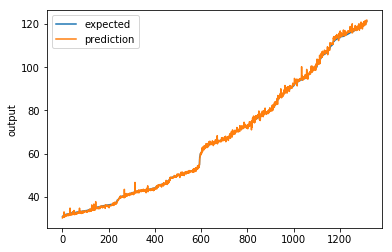

In [83]:
chart_regression(nn_pred.flatten(), y_test)

# LSTM model

In [121]:
df = pd.read_csv('CSC215_Project4_Stock_Price.csv')

In [122]:
df.drop(columns=['Adj_Close','Date'], inplace=True)
df.head()

,Open,High,Low,Close,Volume
0,3.812500,4.156250,3.812500,4.125000,3675600
1,4.125000,4.125000,4.000000,4.015625,1077600
2,4.000000,4.031250,3.953125,4.000000,437200
3,4.000000,4.000000,3.843750,3.843750,1883600
4,3.734375,3.734375,3.390625,3.390625,7931600


In [123]:
SEQUENCE_SIZE = 7
x, y = to_sequences(SEQUENCE_SIZE,df, 'Close')

In [124]:
x = zscore(x)
x_train = x[0:int(0.7*len(x))]
x_test = x[int(0.7*len(x)):]
y_train = y[0:int(0.7*len(y))]
y_test = y[int(0.7*len(y)):]
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
print("Shape of x_train: {}".format(x_train.shape))
print("Shape of x_test: {}".format(x_test.shape))
print("Shape of y_train: {}".format(y_train.shape))
print("Shape of y_test: {}".format(y_test.shape))

Shape of x_train: (3068, 7, 5)
Shape of x_test: (1316, 7, 5)
Shape of y_train: (3068,)
Shape of y_test: (1316,)


In [125]:
checkpointer = ModelCheckpoint(filepath="save/lstm.hdf5", verbose=0, save_best_only=True) # save best model
for i in range(5):
    printmd("\n**Iteration**: {}".format(i))
    #print("\nIteration: {}".format(i))
    model = Sequential()
    model.add(LSTM(50, activation='relu', dropout=0.2, recurrent_dropout=0.18, input_shape=(7, 5)))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor, checkpointer],verbose=2, epochs=1000, batch_size=32)  
    
print('Training finished...Loading the best model')  
print()
model.load_weights("save/lstm.hdf5") # load weights from best model    


**Iteration**: 0

Train on 3068 samples, validate on 1316 samples
Epoch 1/1000
 - 16s - loss: 300.9320 - val_loss: 5813.0772
Epoch 2/1000
 - 2s - loss: 135.9596 - val_loss: 1007.2131
Epoch 3/1000
 - 2s - loss: 35.9053 - val_loss: 303.4555
Epoch 4/1000
 - 2s - loss: 25.2950 - val_loss: 241.1819
Epoch 5/1000
 - 2s - loss: 16.7182 - val_loss: 101.0043
Epoch 6/1000
 - 2s - loss: 13.2214 - val_loss: 88.4555
Epoch 7/1000
 - 2s - loss: 12.7915 - val_loss: 39.8825
Epoch 8/1000
 - 2s - loss: 10.4859 - val_loss: 95.2620
Epoch 9/1000
 - 2s - loss: 9.8650 - val_loss: 86.9293
Epoch 10/1000
 - 2s - loss: 9.7275 - val_loss: 34.4118
Epoch 11/1000
 - 2s - loss: 8.1716 - val_loss: 26.8010
Epoch 12/1000
 - 2s - loss: 7.7335 - val_loss: 21.6333
Epoch 13/1000
 - 2s - loss: 6.5540 - val_loss: 58.6430
Epoch 14/1000
 - 2s - loss: 6.7259 - val_loss: 40.2434
Epoch 15/1000
 - 2s - loss: 6.6184 - val_loss: 17.1496
Epoch 16/1000
 - 2s - loss: 5.9397 - val_loss: 31.4424
Epoch 17/1000
 - 2s - loss: 5.6065 - val_loss: 32.1784
Epoch 18


**Iteration**: 1

Train on 3068 samples, validate on 1316 samples
Epoch 1/1000
 - 15s - loss: 279.9431 - val_loss: 160677.4287
Epoch 2/1000
 - 2s - loss: 87.4229 - val_loss: 14955.0013
Epoch 3/1000
 - 2s - loss: 34.8185 - val_loss: 2152.6834
Epoch 4/1000
 - 2s - loss: 21.0708 - val_loss: 1082.5802
Epoch 5/1000
 - 2s - loss: 16.3647 - val_loss: 689.3818
Epoch 6/1000
 - 2s - loss: 14.4268 - val_loss: 225.9438
Epoch 7/1000
 - 2s - loss: 13.0391 - val_loss: 128.1731
Epoch 8/1000
 - 2s - loss: 11.8062 - val_loss: 36.2807
Epoch 9/1000
 - 2s - loss: 10.4648 - val_loss: 34.6682
Epoch 10/1000
 - 2s - loss: 9.7183 - val_loss: 41.1534
Epoch 11/1000
 - 2s - loss: 8.8223 - val_loss: 48.0214
Epoch 12/1000
 - 2s - loss: 8.8688 - val_loss: 105.6340
Epoch 13/1000
 - 2s - loss: 7.3632 - val_loss: 83.4002
Epoch 14/1000
 - 2s - loss: 7.3471 - val_loss: 44.4774
Epoch 00014: early stopping



**Iteration**: 2

Train on 3068 samples, validate on 1316 samples
Epoch 1/1000
 - 15s - loss: 345.7495 - val_loss: 5758.2398
Epoch 2/1000
 - 2s - loss: 151.6764 - val_loss: 47351.6376
Epoch 3/1000
 - 2s - loss: 64.3887 - val_loss: 7754.9506
Epoch 4/1000
 - 2s - loss: 33.6850 - val_loss: 1132.8704
Epoch 5/1000
 - 2s - loss: 19.9241 - val_loss: 420.7928
Epoch 6/1000
 - 2s - loss: 17.0494 - val_loss: 79.6113
Epoch 7/1000
 - 2s - loss: 14.9556 - val_loss: 20.5110
Epoch 8/1000
 - 2s - loss: 11.9737 - val_loss: 134.2496
Epoch 9/1000
 - 2s - loss: 11.7904 - val_loss: 52.7882
Epoch 10/1000
 - 2s - loss: 10.3482 - val_loss: 76.6751
Epoch 11/1000
 - 2s - loss: 9.1667 - val_loss: 95.9082
Epoch 12/1000
 - 2s - loss: 8.6422 - val_loss: 143.8228
Epoch 00012: early stopping



**Iteration**: 3

Train on 3068 samples, validate on 1316 samples
Epoch 1/1000
 - 16s - loss: 292.9327 - val_loss: 755401.1401
Epoch 2/1000
 - 2s - loss: 175.9176 - val_loss: 54317.3455
Epoch 3/1000
 - 2s - loss: 50.5222 - val_loss: 8653.4246
Epoch 4/1000
 - 2s - loss: 30.7618 - val_loss: 2677.6194
Epoch 5/1000
 - 2s - loss: 25.6293 - val_loss: 1286.5145
Epoch 6/1000
 - 2s - loss: 19.3432 - val_loss: 346.4802
Epoch 7/1000
 - 2s - loss: 16.2660 - val_loss: 113.8030
Epoch 8/1000
 - 2s - loss: 15.3711 - val_loss: 179.5720
Epoch 9/1000
 - 2s - loss: 14.2937 - val_loss: 91.4041
Epoch 10/1000
 - 2s - loss: 13.1949 - val_loss: 78.5971
Epoch 11/1000
 - 2s - loss: 11.8741 - val_loss: 95.6326
Epoch 12/1000
 - 2s - loss: 10.3320 - val_loss: 110.8594
Epoch 13/1000
 - 2s - loss: 10.8714 - val_loss: 178.0841
Epoch 14/1000
 - 2s - loss: 9.5985 - val_loss: 176.7633
Epoch 15/1000
 - 2s - loss: 9.2740 - val_loss: 41.0404
Epoch 16/1000
 - 2s - loss: 8.9137 - val_loss: 224.8587
Epoch 17/1000
 - 2s - loss: 8.1622 - val_loss


**Iteration**: 4

Train on 3068 samples, validate on 1316 samples
Epoch 1/1000
 - 16s - loss: 278.8602 - val_loss: 274357.1051
Epoch 2/1000
 - 2s - loss: 159.8319 - val_loss: 16751.2436
Epoch 3/1000
 - 2s - loss: 38.9446 - val_loss: 5649.2215
Epoch 4/1000
 - 2s - loss: 24.9609 - val_loss: 1192.3216
Epoch 5/1000
 - 2s - loss: 17.3573 - val_loss: 427.5350
Epoch 6/1000
 - 2s - loss: 13.7760 - val_loss: 144.5816
Epoch 7/1000
 - 2s - loss: 11.6861 - val_loss: 16.8327
Epoch 8/1000
 - 2s - loss: 11.1797 - val_loss: 19.5246
Epoch 9/1000
 - 2s - loss: 9.5639 - val_loss: 20.4237
Epoch 10/1000
 - 2s - loss: 9.0543 - val_loss: 85.1945
Epoch 11/1000
 - 2s - loss: 8.8740 - val_loss: 28.0700
Epoch 12/1000
 - 2s - loss: 8.0935 - val_loss: 17.3320
Epoch 00012: early stopping
Training finished...Loading the best model



In [126]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_55 (LSTM)               (None, 50)                11200     
_________________________________________________________________
dense_69 (Dense)             (None, 1)                 51        
Total params: 11,251
Trainable params: 11,251
Non-trainable params: 0
_________________________________________________________________


In [127]:
lstm_pred = model.predict(x_test)
lstm_rmse = np.sqrt(metrics.mean_squared_error(lstm_pred,y_test))
print("Score (RMSE): {}".format(lstm_rmse))

Score (RMSE): 4.1027696627599575


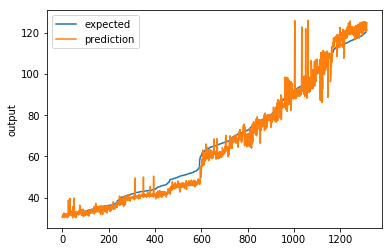

In [128]:
chart_regression(lstm_pred.flatten(), y_test)

In [129]:
checkpointer = ModelCheckpoint(filepath="save/bi_lstm.hdf5", verbose=0, save_best_only=True) # save best model
for i in range(5):
    printmd("\n**Iteration**: {}".format(i))
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu', dropout=0.2, recurrent_dropout=0.18, input_shape=(7, 5))))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor, checkpointer],verbose=2, epochs=1000, batch_size=32)  
    
print('Training finished...Loading the best model')  
print()
model.load_weights("save/bi_lstm.hdf5") # load weights from best model   


**Iteration**: 0

Train on 3068 samples, validate on 1316 samples
Epoch 1/1000
 - 18s - loss: 260.5259 - val_loss: 455466.6818
Epoch 2/1000
 - 3s - loss: 90.4601 - val_loss: 90603.4649
Epoch 3/1000
 - 3s - loss: 28.0605 - val_loss: 12120.9257
Epoch 4/1000
 - 3s - loss: 16.4471 - val_loss: 402.3970
Epoch 5/1000
 - 3s - loss: 9.3517 - val_loss: 86.9109
Epoch 6/1000
 - 3s - loss: 7.8101 - val_loss: 34.4946
Epoch 7/1000
 - 3s - loss: 6.5858 - val_loss: 48.6588
Epoch 8/1000
 - 3s - loss: 6.0078 - val_loss: 42.5080
Epoch 9/1000
 - 3s - loss: 5.0757 - val_loss: 54.9374
Epoch 10/1000
 - 3s - loss: 4.8642 - val_loss: 94.8649
Epoch 11/1000
 - 3s - loss: 4.4505 - val_loss: 85.4848
Epoch 00011: early stopping



**Iteration**: 1

Train on 3068 samples, validate on 1316 samples
Epoch 1/1000
 - 18s - loss: 253.7459 - val_loss: 191522.9671
Epoch 2/1000
 - 3s - loss: 75.4638 - val_loss: 13973.0066
Epoch 3/1000
 - 3s - loss: 22.1488 - val_loss: 4116.9372
Epoch 4/1000
 - 3s - loss: 13.7059 - val_loss: 2166.8991
Epoch 5/1000
 - 3s - loss: 11.1936 - val_loss: 1085.8584
Epoch 6/1000
 - 3s - loss: 9.2843 - val_loss: 476.0098
Epoch 7/1000
 - 3s - loss: 8.4023 - val_loss: 338.0021
Epoch 8/1000
 - 3s - loss: 7.7375 - val_loss: 125.4150
Epoch 9/1000
 - 3s - loss: 6.6132 - val_loss: 96.6023
Epoch 10/1000
 - 3s - loss: 5.8816 - val_loss: 49.2568
Epoch 11/1000
 - 3s - loss: 5.1012 - val_loss: 104.7539
Epoch 12/1000
 - 3s - loss: 5.0645 - val_loss: 67.3725
Epoch 13/1000
 - 3s - loss: 4.3178 - val_loss: 60.9553
Epoch 14/1000
 - 3s - loss: 4.2005 - val_loss: 88.6948
Epoch 15/1000
 - 3s - loss: 3.8871 - val_loss: 42.4341
Epoch 16/1000
 - 3s - loss: 3.5757 - val_loss: 34.2340
Epoch 17/1000
 - 3s - loss: 3.3039 - val_loss: 24.8592
Ep


**Iteration**: 2

Train on 3068 samples, validate on 1316 samples
Epoch 1/1000
 - 20s - loss: 537.6645 - val_loss: 64408.7155
Epoch 2/1000
 - 3s - loss: 143.3341 - val_loss: 113223.1122
Epoch 3/1000
 - 3s - loss: 50.7207 - val_loss: 26499.7352
Epoch 4/1000
 - 3s - loss: 29.3948 - val_loss: 9158.8295
Epoch 5/1000
 - 3s - loss: 16.8205 - val_loss: 4086.1463
Epoch 6/1000
 - 3s - loss: 15.4992 - val_loss: 1366.9960
Epoch 7/1000
 - 3s - loss: 10.7734 - val_loss: 1139.3237
Epoch 8/1000
 - 3s - loss: 10.3722 - val_loss: 628.0893
Epoch 9/1000
 - 3s - loss: 8.7474 - val_loss: 423.7041
Epoch 10/1000
 - 3s - loss: 8.0196 - val_loss: 250.7048
Epoch 11/1000
 - 3s - loss: 8.1108 - val_loss: 147.8218
Epoch 12/1000
 - 3s - loss: 6.9172 - val_loss: 220.6815
Epoch 13/1000
 - 3s - loss: 6.6098 - val_loss: 104.6846
Epoch 14/1000
 - 3s - loss: 6.1175 - val_loss: 158.4502
Epoch 15/1000
 - 3s - loss: 7.0677 - val_loss: 13.4180
Epoch 16/1000
 - 3s - loss: 5.6053 - val_loss: 77.3239
Epoch 17/1000
 - 3s - loss: 5.0692 - val_loss


**Iteration**: 3

Train on 3068 samples, validate on 1316 samples
Epoch 1/1000
 - 19s - loss: 281.2495 - val_loss: 174361.0854
Epoch 2/1000
 - 3s - loss: 100.2521 - val_loss: 57744.8918
Epoch 3/1000
 - 3s - loss: 51.4070 - val_loss: 5949.3303
Epoch 4/1000
 - 3s - loss: 19.6073 - val_loss: 1080.8241
Epoch 5/1000
 - 3s - loss: 13.5591 - val_loss: 604.5111
Epoch 6/1000
 - 3s - loss: 10.7210 - val_loss: 202.6200
Epoch 7/1000
 - 3s - loss: 8.7628 - val_loss: 139.3831
Epoch 8/1000
 - 3s - loss: 8.0868 - val_loss: 22.8124
Epoch 9/1000
 - 3s - loss: 6.4500 - val_loss: 13.5182
Epoch 10/1000
 - 3s - loss: 5.8553 - val_loss: 15.6288
Epoch 11/1000
 - 3s - loss: 5.5164 - val_loss: 20.0244
Epoch 12/1000
 - 3s - loss: 4.5775 - val_loss: 13.8107
Epoch 13/1000
 - 3s - loss: 4.7063 - val_loss: 12.5027
Epoch 14/1000
 - 4s - loss: 4.3296 - val_loss: 22.2052
Epoch 15/1000
 - 4s - loss: 4.3949 - val_loss: 20.4922
Epoch 16/1000
 - 3s - loss: 3.9920 - val_loss: 24.6736
Epoch 17/1000
 - 3s - loss: 3.4482 - val_loss: 17.8455
Epo


**Iteration**: 4

Train on 3068 samples, validate on 1316 samples
Epoch 1/1000
 - 20s - loss: 272.2475 - val_loss: 1185884.4844
Epoch 2/1000
 - 3s - loss: 127.3322 - val_loss: 25721.4088
Epoch 3/1000
 - 3s - loss: 23.6411 - val_loss: 10463.8429
Epoch 4/1000
 - 3s - loss: 18.2376 - val_loss: 5995.6965
Epoch 5/1000
 - 3s - loss: 12.3990 - val_loss: 3517.0314
Epoch 6/1000
 - 3s - loss: 11.4768 - val_loss: 3898.2604
Epoch 7/1000
 - 3s - loss: 9.3915 - val_loss: 2933.1427
Epoch 8/1000
 - 3s - loss: 8.4944 - val_loss: 2741.7587
Epoch 9/1000
 - 3s - loss: 7.8928 - val_loss: 1402.7835
Epoch 10/1000
 - 3s - loss: 6.9846 - val_loss: 1761.6429
Epoch 11/1000
 - 3s - loss: 6.5323 - val_loss: 1069.1260
Epoch 12/1000
 - 3s - loss: 5.7668 - val_loss: 886.0029
Epoch 13/1000
 - 3s - loss: 5.2101 - val_loss: 934.6419
Epoch 14/1000
 - 3s - loss: 4.9666 - val_loss: 370.4983
Epoch 15/1000
 - 3s - loss: 4.5105 - val_loss: 407.2395
Epoch 16/1000
 - 3s - loss: 4.1872 - val_loss: 331.7867
Epoch 17/1000
 - 3s - loss: 4.3113 - val

In [130]:
bi_lstm_pred = model.predict(x_test)
bi_lstm_rmse = np.sqrt(metrics.mean_squared_error(bi_lstm_pred,y_test))
print("Score (RMSE): {}".format(bi_lstm_rmse))

Score (RMSE): 3.5359088122105975


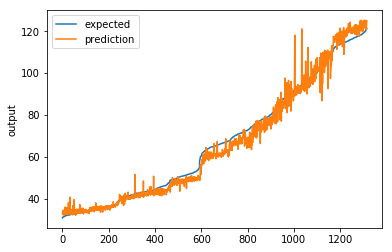

In [131]:
chart_regression(bi_lstm_pred.flatten(), y_test)

In [98]:
checkpointer = ModelCheckpoint(filepath="save/lstm_nodropout.hdf5", verbose=0, save_best_only=True) # save best model
for i in range(5):
    printmd("\n**Iteration**: {}".format(i))
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(7, 5)))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor, checkpointer],verbose=2, epochs=1000, batch_size=32)  
    
print('Training finished...Loading the best model')  
print()
model.load_weights("save/lstm_nodropout.hdf5") # load weights from best model 


**Iteration**: 0

Train on 3068 samples, validate on 1316 samples
Epoch 1/1000
 - 9s - loss: 295.2404 - val_loss: 224006.9113
Epoch 2/1000
 - 2s - loss: 101.9240 - val_loss: 42414.0599
Epoch 3/1000
 - 2s - loss: 13.1702 - val_loss: 8760.4470
Epoch 4/1000
 - 2s - loss: 2.7781 - val_loss: 8390.6391
Epoch 5/1000
 - 2s - loss: 1.7031 - val_loss: 7764.4239
Epoch 6/1000
 - 2s - loss: 1.1901 - val_loss: 7924.1178
Epoch 7/1000
 - 2s - loss: 1.0577 - val_loss: 7450.0115
Epoch 8/1000
 - 2s - loss: 0.9057 - val_loss: 7019.4531
Epoch 9/1000
 - 2s - loss: 0.8428 - val_loss: 6612.7738
Epoch 10/1000
 - 2s - loss: 0.7858 - val_loss: 6535.1475
Epoch 11/1000
 - 2s - loss: 0.7514 - val_loss: 5648.0198
Epoch 12/1000
 - 2s - loss: 0.7452 - val_loss: 5937.1961
Epoch 13/1000
 - 2s - loss: 0.7196 - val_loss: 5341.1393
Epoch 14/1000
 - 2s - loss: 0.6844 - val_loss: 4549.1093
Epoch 15/1000
 - 2s - loss: 0.6780 - val_loss: 3825.2077
Epoch 16/1000
 - 2s - loss: 0.6879 - val_loss: 3783.1736
Epoch 17/1000
 - 2s - loss: 0.6432 - val_


**Iteration**: 1

Train on 3068 samples, validate on 1316 samples
Epoch 1/1000
 - 9s - loss: 303.2895 - val_loss: 1668.5027
Epoch 2/1000
 - 2s - loss: 98.2658 - val_loss: 54019.3879
Epoch 3/1000
 - 2s - loss: 7.2742 - val_loss: 6882.7338
Epoch 4/1000
 - 2s - loss: 1.7024 - val_loss: 5994.0513
Epoch 5/1000
 - 2s - loss: 1.1955 - val_loss: 5528.8436
Epoch 6/1000
 - 2s - loss: 0.9995 - val_loss: 4981.6615
Epoch 00006: early stopping



**Iteration**: 2

Train on 3068 samples, validate on 1316 samples
Epoch 1/1000
 - 9s - loss: 310.6595 - val_loss: 2890.2311
Epoch 2/1000
 - 2s - loss: 135.8003 - val_loss: 75651.4250
Epoch 3/1000
 - 2s - loss: 15.4506 - val_loss: 11403.9155
Epoch 4/1000
 - 2s - loss: 1.9039 - val_loss: 7620.7881
Epoch 5/1000
 - 2s - loss: 1.1213 - val_loss: 5654.3884
Epoch 6/1000
 - 2s - loss: 0.9362 - val_loss: 4952.5711
Epoch 00006: early stopping



**Iteration**: 3

Train on 3068 samples, validate on 1316 samples
Epoch 1/1000
 - 10s - loss: 353.1962 - val_loss: 414394.0105
Epoch 2/1000
 - 2s - loss: 97.4567 - val_loss: 113550.6414
Epoch 3/1000
 - 2s - loss: 32.4277 - val_loss: 25201.0013
Epoch 4/1000
 - 2s - loss: 7.0966 - val_loss: 9434.5939
Epoch 5/1000
 - 2s - loss: 2.2692 - val_loss: 6215.6450
Epoch 6/1000
 - 2s - loss: 1.4183 - val_loss: 3847.0672
Epoch 7/1000
 - 2s - loss: 1.0082 - val_loss: 2898.4719
Epoch 8/1000
 - 2s - loss: 0.7852 - val_loss: 2280.5538
Epoch 9/1000
 - 2s - loss: 0.6854 - val_loss: 1875.1496
Epoch 10/1000
 - 2s - loss: 0.5972 - val_loss: 1613.3173
Epoch 11/1000
 - 2s - loss: 0.5480 - val_loss: 1405.4684
Epoch 12/1000
 - 2s - loss: 0.5250 - val_loss: 1430.3463
Epoch 13/1000
 - 2s - loss: 0.4998 - val_loss: 1383.1952
Epoch 14/1000
 - 2s - loss: 0.4922 - val_loss: 1397.0498
Epoch 15/1000
 - 2s - loss: 0.4700 - val_loss: 1259.3281
Epoch 16/1000
 - 2s - loss: 0.4517 - val_loss: 1149.3014
Epoch 17/1000
 - 2s - loss: 0.4520 - va


**Iteration**: 4

Train on 3068 samples, validate on 1316 samples
Epoch 1/1000
 - 9s - loss: 303.2904 - val_loss: 3597.9236
Epoch 2/1000
 - 2s - loss: 149.6923 - val_loss: 23523.2753
Epoch 3/1000
 - 2s - loss: 7.7020 - val_loss: 7451.0611
Epoch 4/1000
 - 2s - loss: 1.8582 - val_loss: 5935.1561
Epoch 5/1000
 - 2s - loss: 1.2731 - val_loss: 4519.2228
Epoch 6/1000
 - 2s - loss: 1.0260 - val_loss: 6499.4755
Epoch 00006: early stopping
Training finished...Loading the best model



In [99]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_35 (LSTM)               (None, 50)                11200     
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 51        
Total params: 11,251
Trainable params: 11,251
Non-trainable params: 0
_________________________________________________________________


In [100]:
lstm_nodropout_pred = model.predict(x_test)
lstm_nodropout_rmse = np.sqrt(metrics.mean_squared_error(lstm_nodropout_pred,y_test))
print("Score (RMSE): {}".format(lstm_nodropout_rmse))

Score (RMSE): 11.008483803311481


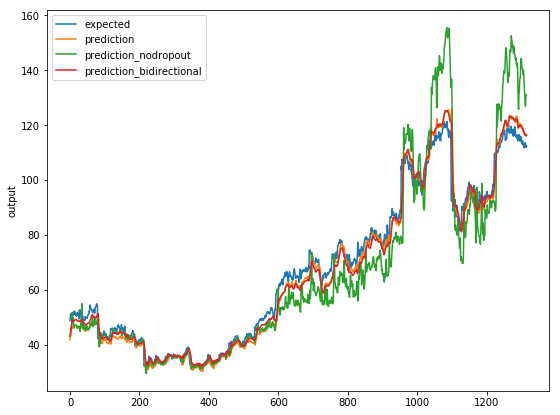

In [132]:
t = pd.DataFrame({'pred' : lstm_pred.flatten(), 'pred_nodropout': lstm_nodropout_pred.flatten(), 'bi_pred': bi_lstm_pred.flatten(), 'y' : y_test.flatten()})   
plt.figure(figsize=(9,7))
a = plt.plot(t['y'].tolist(),label='expected')
b = plt.plot(t['pred'].tolist(),label='prediction')
c = plt.plot(t['pred_nodropout'].tolist(),label='prediction_nodropout')
d = plt.plot(t['bi_pred'].tolist(),label='prediction_bidirectional')
plt.ylabel('output')
plt.legend()
plt.show()    

# CNN model

In [102]:
df = pd.read_csv('CSC215_Project4_Stock_Price.csv')

In [103]:
df.drop(columns=['Adj_Close','Date'], inplace=True)
df.head()

,Open,High,Low,Close,Volume
0,3.812500,4.156250,3.812500,4.125000,3675600
1,4.125000,4.125000,4.000000,4.015625,1077600
2,4.000000,4.031250,3.953125,4.000000,437200
3,4.000000,4.000000,3.843750,3.843750,1883600
4,3.734375,3.734375,3.390625,3.390625,7931600


In [104]:
SEQUENCE_SIZE = 7
x, y = to_sequences(SEQUENCE_SIZE,df, 'Close')
x = zscore(x)

print("Shape of x: {}".format(x.shape))
print("Shape of y: {}".format(y.shape))

Shape of x: (4384, 7, 5)
Shape of y: (4384,)


In [105]:
x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)
print(x.shape)

(4384, 7, 5, 1)


In [106]:
x_train = x[0:int(0.7*len(x))]
x_test = x[int(0.7*len(x)):]
y_train = y[0:int(0.7*len(y))]
y_test = y[int(0.7*len(y)):]
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
print("Shape of x_train: {}".format(x_train.shape))
print("Shape of x_test: {}".format(x_test.shape))
print("Shape of y_train: {}".format(y_train.shape))
print("Shape of y_test: {}".format(y_test.shape))

Shape of x_train: (3068, 7, 5, 1)
Shape of x_test: (1316, 7, 5, 1)
Shape of y_train: (3068,)
Shape of y_test: (1316,)


In [107]:
checkpointer = ModelCheckpoint(filepath="save/cnn.hdf5", verbose=0, save_best_only=True) # save best model
input_shape = (7, 5, 1)
for i in range(5):
    printmd("\n**Iteration**: {}".format(i))
    #Build network
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(1, 2), strides=(1, 1), padding='valid',
                 activation='relu',
                 input_shape=input_shape))
    model.add(Conv2D(64, (1, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 2), strides=None))
    model.add(Dropout(0.25)) 
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))

    model.compile(loss="mean_squared_error", optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train,y_train, validation_data=(x_test,y_test), callbacks=[monitor,checkpointer],verbose=2,epochs=1000, batch_size=64, shuffle=True)    # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
    
    
print('Training finished...Loading the best model')  
print()
model.load_weights('save/cnn.hdf5') # load weights from best model



**Iteration**: 0

Train on 3068 samples, validate on 1316 samples
Epoch 1/1000
 - 9s - loss: 202.8486 - val_loss: 1699.0953
Epoch 2/1000
 - 0s - loss: 26.9339 - val_loss: 1195.3121
Epoch 3/1000
 - 0s - loss: 10.9505 - val_loss: 259.3865
Epoch 4/1000
 - 0s - loss: 7.3066 - val_loss: 35.0574
Epoch 5/1000
 - 0s - loss: 6.5212 - val_loss: 26.0220
Epoch 6/1000
 - 0s - loss: 6.0993 - val_loss: 11.1197
Epoch 7/1000
 - 0s - loss: 6.5412 - val_loss: 48.7897
Epoch 8/1000
 - 0s - loss: 6.1445 - val_loss: 27.0944
Epoch 9/1000
 - 0s - loss: 5.9714 - val_loss: 49.1530
Epoch 10/1000
 - 0s - loss: 6.2275 - val_loss: 59.5905
Epoch 11/1000
 - 0s - loss: 6.0093 - val_loss: 30.5623
Epoch 00011: early stopping



**Iteration**: 1

Train on 3068 samples, validate on 1316 samples
Epoch 1/1000
 - 8s - loss: 208.7499 - val_loss: 1321.7572
Epoch 2/1000
 - 0s - loss: 29.6400 - val_loss: 927.6749
Epoch 3/1000
 - 0s - loss: 8.9600 - val_loss: 183.0550
Epoch 4/1000
 - 0s - loss: 6.4877 - val_loss: 77.1908
Epoch 5/1000
 - 0s - loss: 5.9658 - val_loss: 99.8735
Epoch 6/1000
 - 0s - loss: 6.2125 - val_loss: 50.4017
Epoch 7/1000
 - 0s - loss: 5.6579 - val_loss: 63.1628
Epoch 8/1000
 - 0s - loss: 6.2549 - val_loss: 61.6111
Epoch 9/1000
 - 0s - loss: 5.9451 - val_loss: 65.4932
Epoch 10/1000
 - 0s - loss: 5.6001 - val_loss: 74.4885
Epoch 11/1000
 - 0s - loss: 6.2372 - val_loss: 43.9948
Epoch 12/1000
 - 0s - loss: 6.4560 - val_loss: 49.6672
Epoch 13/1000
 - 0s - loss: 6.1123 - val_loss: 40.1538
Epoch 14/1000
 - 0s - loss: 5.8767 - val_loss: 55.9601
Epoch 15/1000
 - 0s - loss: 5.7595 - val_loss: 19.1173
Epoch 16/1000
 - 0s - loss: 5.3829 - val_loss: 28.2074
Epoch 17/1000
 - 0s - loss: 5.8777 - val_loss: 36.1290
Epoch 18/1000
 - 0s


**Iteration**: 2

Train on 3068 samples, validate on 1316 samples
Epoch 1/1000
 - 8s - loss: 199.9206 - val_loss: 3727.9574
Epoch 2/1000
 - 0s - loss: 26.2329 - val_loss: 1014.4769
Epoch 3/1000
 - 0s - loss: 9.5403 - val_loss: 84.5354
Epoch 4/1000
 - 0s - loss: 6.1545 - val_loss: 21.8662
Epoch 5/1000
 - 0s - loss: 6.5682 - val_loss: 26.9562
Epoch 6/1000
 - 0s - loss: 5.9687 - val_loss: 28.0753
Epoch 7/1000
 - 0s - loss: 5.9262 - val_loss: 24.8005
Epoch 8/1000
 - 0s - loss: 5.9862 - val_loss: 27.8279
Epoch 9/1000
 - 0s - loss: 6.3507 - val_loss: 84.1391
Epoch 00009: early stopping



**Iteration**: 3

Train on 3068 samples, validate on 1316 samples
Epoch 1/1000
 - 8s - loss: 224.6651 - val_loss: 306.6466
Epoch 2/1000
 - 0s - loss: 30.3708 - val_loss: 746.8496
Epoch 3/1000
 - 0s - loss: 11.2094 - val_loss: 135.5284
Epoch 4/1000
 - 0s - loss: 7.4591 - val_loss: 17.8047
Epoch 5/1000
 - 0s - loss: 6.7166 - val_loss: 9.2078
Epoch 6/1000
 - 0s - loss: 6.5539 - val_loss: 7.2166
Epoch 7/1000
 - 0s - loss: 6.3984 - val_loss: 8.3104
Epoch 8/1000
 - 0s - loss: 6.4926 - val_loss: 8.4842
Epoch 9/1000
 - 0s - loss: 6.9527 - val_loss: 7.3283
Epoch 10/1000
 - 0s - loss: 6.4095 - val_loss: 7.8495
Epoch 11/1000
 - 0s - loss: 6.4882 - val_loss: 7.4664
Epoch 00011: early stopping



**Iteration**: 4

Train on 3068 samples, validate on 1316 samples
Epoch 1/1000
 - 8s - loss: 229.8859 - val_loss: 165.1372
Epoch 2/1000
 - 0s - loss: 26.7648 - val_loss: 759.6540
Epoch 3/1000
 - 0s - loss: 8.7674 - val_loss: 69.8145
Epoch 4/1000
 - 0s - loss: 6.1702 - val_loss: 79.7407
Epoch 5/1000
 - 0s - loss: 6.1292 - val_loss: 19.7078
Epoch 6/1000
 - 0s - loss: 5.8860 - val_loss: 9.6987
Epoch 7/1000
 - 0s - loss: 5.7946 - val_loss: 10.2437
Epoch 8/1000
 - 0s - loss: 6.3927 - val_loss: 9.9949
Epoch 9/1000
 - 0s - loss: 6.1570 - val_loss: 30.4997
Epoch 10/1000
 - 0s - loss: 5.3605 - val_loss: 9.7269
Epoch 11/1000
 - 0s - loss: 6.0568 - val_loss: 9.7594
Epoch 00011: early stopping
Training finished...Loading the best model



In [108]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 7, 4, 32)          96        
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 3, 64)          4160      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 1, 64)          0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 7, 1, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 448)               0         
_________________________________________________________________
dense_58 (Dense)             (None, 128)               57472     
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)               0         
__________

In [109]:
cnn_pred = model.predict(x_test)
cnn_rmse = np.sqrt(metrics.mean_squared_error(cnn_pred,y_test))
print("Score (RMSE): {}".format(cnn_rmse))

Score (RMSE): 2.686379350934843


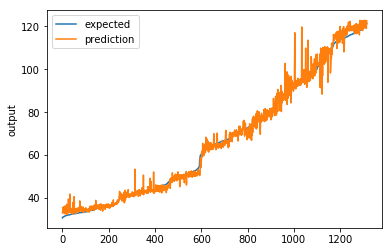

In [110]:
chart_regression(cnn_pred.flatten(), y_test)

# Additional Feature

## Predicting Google's stock for the next 3 days

In [5]:
df = pd.read_csv('GOOG.csv')

In [6]:
df.drop(columns=['Adj Close','Date'], inplace=True)
df.shape

(3578, 5)

In [7]:
x, y = to_sequences_continuous(7, df, 'Close', 3)

In [8]:
x = zscore(x)
x_train = x[0:int(0.7*len(x))]
x_test = x[int(0.7*len(x)):]
y_train = y[0:int(0.7*len(y))]
y_test = y[int(0.7*len(y)):]
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
print("Shape of x_train: {}".format(x_train.shape))
print("Shape of x_test: {}".format(x_test.shape))
print("Shape of y_train: {}".format(y_train.shape))
print("Shape of y_test: {}".format(y_test.shape))

Shape of x_train: (2496, 7, 5)
Shape of x_test: (1071, 7, 5)
Shape of y_train: (2496, 3)
Shape of y_test: (1071, 3)


In [9]:
checkpointer = ModelCheckpoint(filepath="save/continuous_3.hdf5", verbose=0, save_best_only=True) # save best model
for i in range(5):
    printmd("\n**Iteration**: {}".format(i))
    model = Sequential()
    model.add(Bidirectional(LSTM(512, activation='relu', dropout=0.25, recurrent_dropout=0.18, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))))
    model.add(Bidirectional(LSTM(512, activation='relu', dropout=0.25, recurrent_dropout=0.18, return_sequences=False)))
    model.add(Dense(y_train.shape[1]))

    model.compile(loss='mean_squared_error', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor, checkpointer],verbose=2, epochs=1000, batch_size=32)  
    
print('Training finished...Loading the best model')  
print()


**Iteration**: 0

Train on 2496 samples, validate on 1071 samples
Epoch 1/1000
 - 13s - loss: 36647.0349 - val_loss: 1291601.0329
Epoch 2/1000
 - 5s - loss: 3282.5977 - val_loss: 6291.9336
Epoch 3/1000
 - 4s - loss: 1762.8163 - val_loss: 2786.8907
Epoch 4/1000
 - 4s - loss: 1404.4664 - val_loss: 2171.7696
Epoch 5/1000
 - 4s - loss: 1170.9368 - val_loss: 1340.4434
Epoch 6/1000
 - 4s - loss: 1034.4632 - val_loss: 2098.7680
Epoch 7/1000
 - 4s - loss: 709.4143 - val_loss: 5631.1699
Epoch 8/1000
 - 4s - loss: 754.0801 - val_loss: 9097.6019
Epoch 9/1000
 - 5s - loss: 625.7763 - val_loss: 3892.7080
Epoch 10/1000
 - 4s - loss: 601.8465 - val_loss: 7295.5027
Epoch 00010: early stopping



**Iteration**: 1

Train on 2496 samples, validate on 1071 samples
Epoch 1/1000
 - 11s - loss: 45687.8416 - val_loss: 334798.4125
Epoch 2/1000
 - 5s - loss: 4378.6206 - val_loss: 17422.3716
Epoch 3/1000
 - 5s - loss: 1776.1590 - val_loss: 4673.9109
Epoch 4/1000
 - 5s - loss: 1128.3682 - val_loss: 17397.9267
Epoch 5/1000
 - 5s - loss: 918.0209 - val_loss: 3582.5983
Epoch 6/1000
 - 5s - loss: 845.1591 - val_loss: 11219.3109
Epoch 7/1000
 - 5s - loss: 687.8068 - val_loss: 7601.9244
Epoch 8/1000
 - 5s - loss: 667.0346 - val_loss: 9577.5266
Epoch 9/1000
 - 5s - loss: 723.3102 - val_loss: 36524.5810
Epoch 10/1000
 - 5s - loss: 657.3614 - val_loss: 10794.0297
Epoch 00010: early stopping



**Iteration**: 2

Train on 2496 samples, validate on 1071 samples
Epoch 1/1000
 - 12s - loss: 27997.7517 - val_loss: 24541.3757
Epoch 2/1000
 - 5s - loss: 2487.4617 - val_loss: 3603.7790
Epoch 3/1000
 - 5s - loss: 1340.8484 - val_loss: 4144.5132
Epoch 4/1000
 - 5s - loss: 928.8021 - val_loss: 16189.6661
Epoch 5/1000
 - 5s - loss: 850.7996 - val_loss: 11840.7286
Epoch 6/1000
 - 5s - loss: 671.3516 - val_loss: 7217.9333
Epoch 7/1000
 - 5s - loss: 667.4219 - val_loss: 13714.3165
Epoch 00007: early stopping



**Iteration**: 3

Train on 2496 samples, validate on 1071 samples
Epoch 1/1000
 - 12s - loss: 61840.1092 - val_loss: 195583.5576
Epoch 2/1000
 - 5s - loss: 6672.6345 - val_loss: 3139.8143
Epoch 3/1000
 - 5s - loss: 2344.9253 - val_loss: 8186.2533
Epoch 4/1000
 - 5s - loss: 1659.1162 - val_loss: 3932.1065
Epoch 5/1000
 - 4s - loss: 1207.8233 - val_loss: 13580.3631
Epoch 6/1000
 - 5s - loss: 1022.5461 - val_loss: 24731.2988
Epoch 7/1000
 - 5s - loss: 981.6784 - val_loss: 11393.8894
Epoch 00007: early stopping



**Iteration**: 4

Train on 2496 samples, validate on 1071 samples
Epoch 1/1000
 - 13s - loss: 26883.8993 - val_loss: 16177.9683
Epoch 2/1000
 - 5s - loss: 2559.7715 - val_loss: 11962.8295
Epoch 3/1000
 - 5s - loss: 1407.6039 - val_loss: 3731.9365
Epoch 4/1000
 - 5s - loss: 966.4617 - val_loss: 4884.7330
Epoch 5/1000
 - 5s - loss: 752.7103 - val_loss: 3321.6323
Epoch 6/1000
 - 5s - loss: 619.8979 - val_loss: 6352.8159
Epoch 7/1000
 - 5s - loss: 624.6977 - val_loss: 21420.8117
Epoch 8/1000
 - 5s - loss: 584.1094 - val_loss: 56761.3357
Epoch 9/1000
 - 5s - loss: 594.3222 - val_loss: 16107.7189
Epoch 10/1000
 - 5s - loss: 541.0804 - val_loss: 63189.0178
Epoch 00010: early stopping
Training finished...Loading the best model



In [10]:
model.load_weights("save/continuous_3.hdf5") # load weights from best model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_9 (Bidirection (None, 7, 1024)           2121728   
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 1024)              6295552   
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 3075      
Total params: 8,420,355
Trainable params: 8,420,355
Non-trainable params: 0
_________________________________________________________________


In [11]:
continuous_3_pred = model.predict(x_test)
continuous_3_rmse = np.sqrt(metrics.mean_squared_error(continuous_3_pred,y_test))
print("Score (RMSE): {}".format(continuous_3_rmse))

Score (RMSE): 36.612067039566206


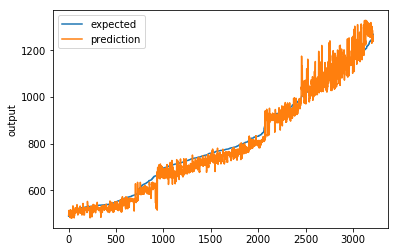

In [12]:
chart_regression(continuous_3_pred.flatten(), y_test)

In [13]:
print("Sample comparision result: \n")
print("          Predicted           Real")
for i in range(3):
    print("Day {}:".format(i+1), end =" ")   
    print("   {:.4f}           {:.4f}".format(continuous_3_pred[19][i], y_test[19][i]))


Sample comparision result: 

          Predicted           Real
Day 1:    559.8802           574.7000
Day 2:    565.8223           567.8775
Day 3:    560.5074           566.0873


## Predicting Google's stock for the next 7 days

In [151]:
df = pd.read_csv('GOOG.csv')

In [152]:
df.drop(columns=['Adj Close','Date'], inplace=True)
df.shape

(3578, 5)

In [153]:
x, y = to_sequences_continuous(7, df, 'Close', 7)

In [154]:
x = zscore(x)
x_train = x[0:int(0.7*len(x))]
x_test = x[int(0.7*len(x)):]
y_train = y[0:int(0.7*len(y))]
y_test = y[int(0.7*len(y)):]
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
print("Shape of x_train: {}".format(x_train.shape))
print("Shape of x_test: {}".format(x_test.shape))
print("Shape of y_train: {}".format(y_train.shape))
print("Shape of y_test: {}".format(y_test.shape))

Shape of x_train: (2494, 7, 5)
Shape of x_test: (1069, 7, 5)
Shape of y_train: (2494, 7)
Shape of y_test: (1069, 7)


In [155]:
checkpointer = ModelCheckpoint(filepath="save/continuous.hdf5", verbose=0, save_best_only=True) # save best model
for i in range(5):
    printmd("\n**Iteration**: {}".format(i))
    model = Sequential()
    model.add(Bidirectional(LSTM(512, activation='relu', dropout=0.25, recurrent_dropout=0.18, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))))
    model.add(Bidirectional(LSTM(512, activation='relu', dropout=0.25, recurrent_dropout=0.18, return_sequences=False)))
    model.add(Dense(7))

    model.compile(loss='mean_squared_error', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor, checkpointer],verbose=2, epochs=1000, batch_size=32)  
    
print('Training finished...Loading the best model')  
print()


**Iteration**: 0

Train on 2494 samples, validate on 1069 samples
Epoch 1/1000
 - 51s - loss: 80069.3998 - val_loss: 92147.9905
Epoch 2/1000
 - 9s - loss: 7501.0684 - val_loss: 13207.1237
Epoch 3/1000
 - 9s - loss: 3008.4668 - val_loss: 72113.4973
Epoch 4/1000
 - 9s - loss: 2186.9635 - val_loss: 9178.8336
Epoch 5/1000
 - 9s - loss: 1635.5376 - val_loss: 17009.3777
Epoch 6/1000
 - 9s - loss: 1424.3091 - val_loss: 26743.0127
Epoch 7/1000
 - 9s - loss: 1178.0850 - val_loss: 15298.6000
Epoch 8/1000
 - 9s - loss: 1074.7350 - val_loss: 26103.3970
Epoch 9/1000
 - 9s - loss: 938.5138 - val_loss: 44909.9303
Epoch 00009: early stopping



**Iteration**: 1

Train on 2494 samples, validate on 1069 samples
Epoch 1/1000
 - 52s - loss: 34296.4177 - val_loss: 34844.9469
Epoch 2/1000
 - 10s - loss: 3115.6616 - val_loss: 3031.8711
Epoch 3/1000
 - 10s - loss: 2021.5126 - val_loss: 5286.0194
Epoch 4/1000
 - 10s - loss: 1270.1433 - val_loss: 2606.6384
Epoch 5/1000
 - 10s - loss: 1039.9670 - val_loss: 6736.0760
Epoch 6/1000
 - 10s - loss: 768.9717 - val_loss: 4390.3442
Epoch 7/1000
 - 10s - loss: 728.2489 - val_loss: 4112.1749
Epoch 8/1000
 - 10s - loss: 646.5925 - val_loss: 22857.4688
Epoch 9/1000
 - 10s - loss: 635.2518 - val_loss: 6110.8731
Epoch 00009: early stopping



**Iteration**: 2

Train on 2494 samples, validate on 1069 samples
Epoch 1/1000
 - 53s - loss: 63364.8063 - val_loss: 1168189.6540
Epoch 2/1000
 - 9s - loss: 5951.5681 - val_loss: 56585.6352
Epoch 3/1000
 - 9s - loss: 2833.3064 - val_loss: 47114.1811
Epoch 4/1000
 - 9s - loss: 1936.6211 - val_loss: 91034.4863
Epoch 5/1000
 - 9s - loss: 1464.9026 - val_loss: 40007.6739
Epoch 6/1000
 - 9s - loss: 1149.1269 - val_loss: 78681.0589
Epoch 7/1000
 - 10s - loss: 1102.2300 - val_loss: 44135.5433
Epoch 8/1000
 - 9s - loss: 875.9710 - val_loss: 25842.6879
Epoch 9/1000
 - 9s - loss: 807.5642 - val_loss: 33446.7368
Epoch 10/1000
 - 9s - loss: 732.1450 - val_loss: 65787.7530
Epoch 11/1000
 - 9s - loss: 678.3067 - val_loss: 29712.9483
Epoch 12/1000
 - 9s - loss: 644.3206 - val_loss: 35877.5842
Epoch 13/1000
 - 9s - loss: 610.8796 - val_loss: 39711.1650
Epoch 00013: early stopping



**Iteration**: 3

Train on 2494 samples, validate on 1069 samples
Epoch 1/1000
 - 54s - loss: 49918.4155 - val_loss: 61840.4223
Epoch 2/1000
 - 10s - loss: 4307.8641 - val_loss: 1969.9019
Epoch 3/1000
 - 10s - loss: 2036.9112 - val_loss: 3844.2092
Epoch 4/1000
 - 10s - loss: 1692.2036 - val_loss: 4466.0594
Epoch 5/1000
 - 10s - loss: 1365.4572 - val_loss: 1480.4014
Epoch 6/1000
 - 10s - loss: 1142.1889 - val_loss: 4399.9912
Epoch 7/1000
 - 10s - loss: 932.6584 - val_loss: 6903.6316
Epoch 8/1000
 - 10s - loss: 827.4728 - val_loss: 1674.8458
Epoch 9/1000
 - 10s - loss: 865.8157 - val_loss: 12502.3603
Epoch 10/1000
 - 10s - loss: 909.2911 - val_loss: 2377.6199
Epoch 00010: early stopping



**Iteration**: 4

Train on 2494 samples, validate on 1069 samples
Epoch 1/1000
 - 55s - loss: 57047.8666 - val_loss: 1362285.3308
Epoch 2/1000
 - 10s - loss: 6025.4942 - val_loss: 133234.5713
Epoch 3/1000
 - 10s - loss: 2925.8106 - val_loss: 53801.3601
Epoch 4/1000
 - 10s - loss: 1999.1052 - val_loss: 19394.4981
Epoch 5/1000
 - 10s - loss: 1721.8610 - val_loss: 20884.1953
Epoch 6/1000
 - 10s - loss: 1440.5499 - val_loss: 38799.3800
Epoch 7/1000
 - 10s - loss: 1073.4856 - val_loss: 52866.9930
Epoch 8/1000
 - 10s - loss: 993.3482 - val_loss: 44388.1697
Epoch 9/1000
 - 10s - loss: 867.5251 - val_loss: 33151.8012
Epoch 00009: early stopping
Training finished...Loading the best model



In [156]:
model.load_weights("save/continuous.hdf5") # load weights from best model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_94 (Bidirectio (None, 7, 1024)           2121728   
_________________________________________________________________
bidirectional_95 (Bidirectio (None, 1024)              6295552   
_________________________________________________________________
dense_89 (Dense)             (None, 7)                 7175      
Total params: 8,424,455
Trainable params: 8,424,455
Non-trainable params: 0
_________________________________________________________________


In [157]:
continuous_pred = model.predict(x_test)
continuous_rmse = np.sqrt(metrics.mean_squared_error(continuous_pred,y_test))
print("Score (RMSE): {}".format(continuous_rmse))

Score (RMSE): 38.4759843724456


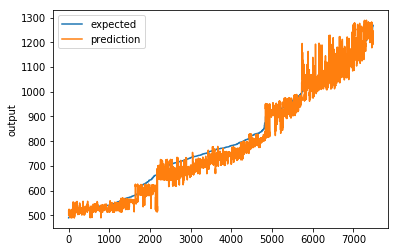

In [158]:
chart_regression(continuous_pred.flatten(), y_test)

In [159]:
print("Sample comparision result: \n")
print("          Predicted           Real")
for i in range(7):
    print("Day {}:".format(i+1), end =" ")   
    print("   {:.4f}           {:.4f}".format(continuous_pred[19][i], y_test[19][i]))


Sample comparision result: 

          Predicted           Real
Day 1:    558.7465           579.3743
Day 2:    559.3696           577.0272
Day 3:    557.5245           574.7000
Day 4:    557.8124           567.8775
Day 5:    562.1210           566.0873
Day 6:    559.4254           568.4742
Day 7:    562.6073           574.1729
